In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.mixture import GaussianMixture as mix

# our implementation

In [2]:
def gaussian_mixture(x, k, iter=0, cus= None):
  #initialize
  #means = random points
  #covar = unit variance
  #pi = uniform based on k

  perm = torch.randperm(x.size(0))
  idx = perm[:k]
  means = x[idx]
  if cus != None:
    means = cus
  covar = torch.eye(x.size(1), dtype=torch.float).repeat(k,1,1)
  pi = torch.ones(k, dtype=torch.float)/k
  gammas = torch.zeros((x.size(0), k), dtype=torch.float)
  nk = torch.zeros((k), dtype=torch.float)

  for i in range(k):
    gauss = MultivariateNormal(means[i], covar[i])
    gammas[:,i] = pi[i] * torch.exp(gauss.log_prob(x))

  loglike = torch.sum(torch.log(torch.sum(gammas, 1)))

  print(loglike)
  for it in range(iter):
    # E step   
    gammas = gammas / torch.sum(gammas, 1).reshape(-1,1)
    nk = torch.sum(gammas, 0)

    # M step
    for i in range(k):
      means[i] = (1/nk[i]) * torch.sum(x*gammas[:,[i]], 0)
      covar[i] = (1/nk[i]) * (gammas[:,[i]]* (x - means[i])).T @  (x - means[i])
      pi[i] = nk[i] / x.shape[0]

    # eval step
    for i in range(k):
      gauss = MultivariateNormal(means[i], covar[i])
      gammas[:,i] = pi[i] * torch.exp(gauss.log_prob(x))
    loglike = torch.sum(torch.log(torch.sum(gammas, 1)))

    print(loglike)

  gammas = gammas / torch.sum(gammas, 1).reshape(-1,1)
  return means, covar, pi, gammas

# test synthetic data

In [3]:
mean_1 = [3,6]
mean_2 = [2,2]
mean_3 = [6,3]

std_1 = [0.5,2]
std_2 = [0.5,1]
std_3 = [0.5,0.5]

data_points = 200

normal_1 = torch.normal(mean=torch.tensor(mean_1*data_points, dtype=torch.float), std = torch.tensor(std_1*data_points, dtype=torch.float)).reshape(data_points,-1)
normal_2 = torch.normal(mean=torch.tensor(mean_2*data_points, dtype=torch.float), std = torch.tensor(std_2*data_points, dtype=torch.float)).reshape(data_points,-1)
normal_3 = torch.normal(mean=torch.tensor(mean_3*data_points, dtype=torch.float), std = torch.tensor(std_3*data_points, dtype=torch.float)).reshape(data_points,-1)

data = torch.cat([normal_1, normal_2, normal_3])

In [4]:
m, c, p, g = gaussian_mixture(data, 3, iter=10)

tensor(-2405.0713)
tensor(-1980.3090)
tensor(-1917.2762)
tensor(-1894.5968)
tensor(-1890.4667)
tensor(-1887.5696)
tensor(-1885.3297)
tensor(-1883.7161)
tensor(-1882.6295)
tensor(-1881.9329)
tensor(-1881.4984)


In [5]:
print(m)

tensor([[2.0060, 2.0184],
        [3.0249, 6.1990],
        [5.9788, 3.0477]])


# sklearn version on synthetic data

In [6]:
model = mix(n_components = 3)

In [7]:
model.fit(data)

GaussianMixture(n_components=3)

In [8]:
print(model.means_)

[[1.99975348 2.0064766 ]
 [3.02164402 6.171367  ]
 [5.9788054  3.04767621]]


# import mnist

In [9]:
import torchvision
import torchvision.transforms as transforms
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=True, 
                                       transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=False, 
                                       transform=transforms.ToTensor(),  
                                           download=True)

In [10]:
x = torch.empty(0)
y = torch.empty(0)
x_test = torch.empty(0)
y_test = torch.empty(0)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=1024, 
                                            shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=1024, 
                                            shuffle=False)
for xs,i in train_loader:
  x = torch.cat([x,xs])
  y = torch.cat([y,i])
  
for xs,i in test_loader:
  x_test = torch.cat([x_test,xs])
  y_test = torch.cat([y_test,i])
  
x_reshape = x.reshape(-1, 28*28)
x_test_reshape = x_test.reshape(-1, 28*28)

# sklearn gmm on mnist

In [11]:
model2 = mix(n_components = 10)
model2.fit(x_reshape)

GaussianMixture(n_components=10)

In [17]:
print(model2.score(x_test_reshape))

2280.4257510323487


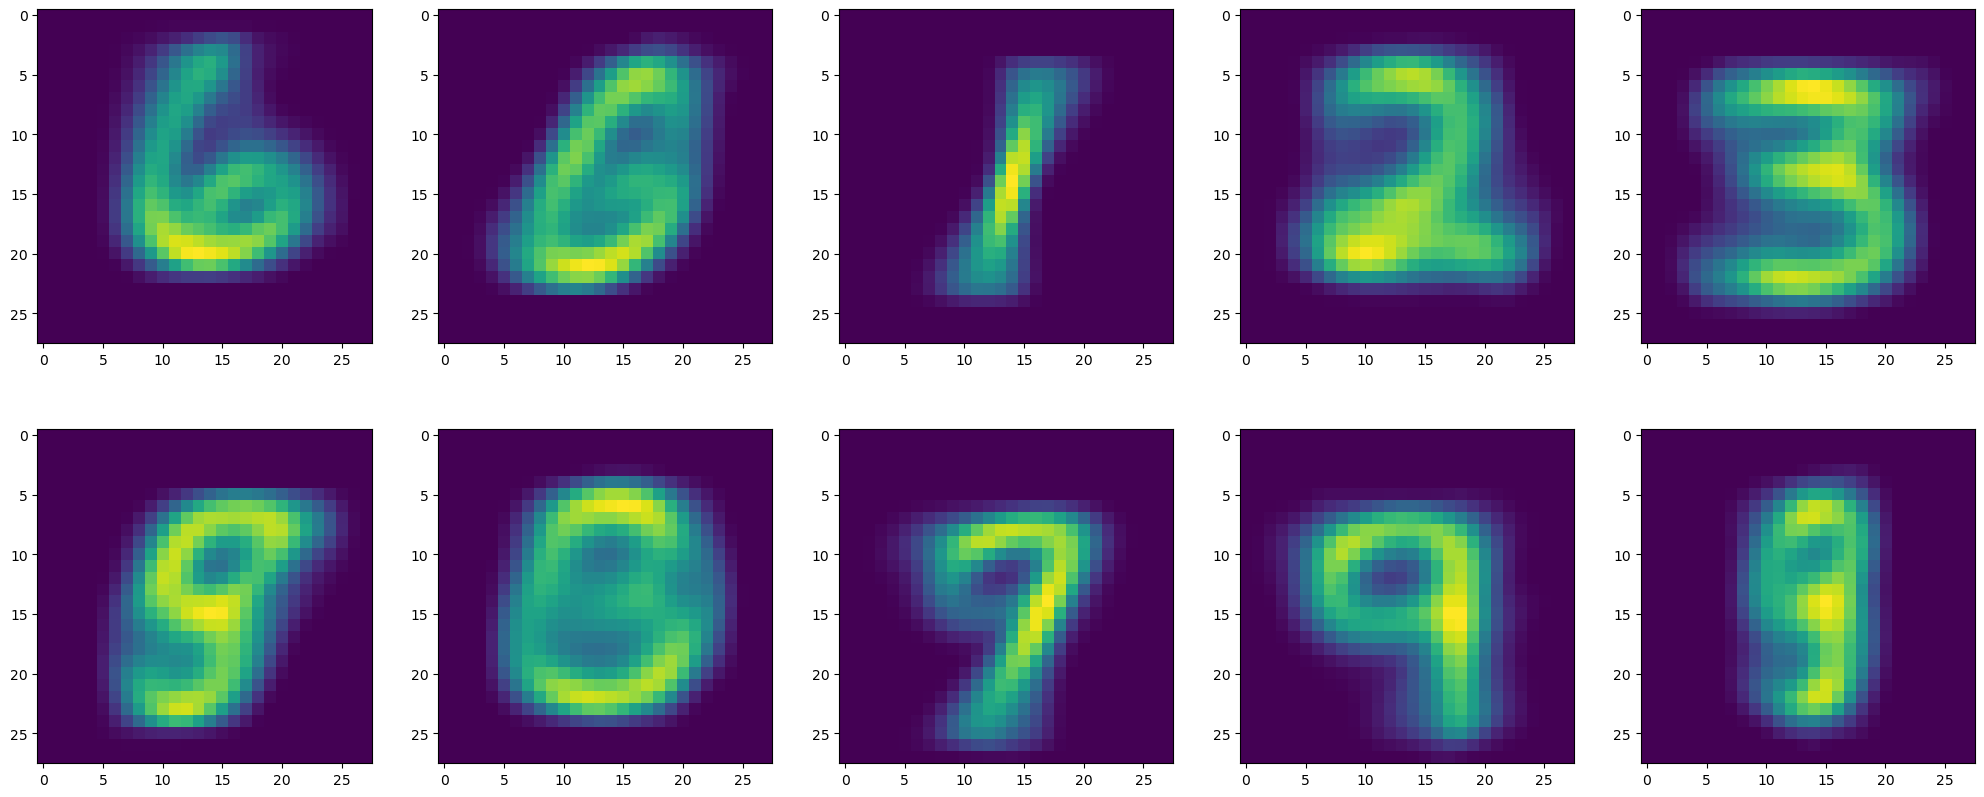

In [14]:
fig, ax = plt.subplots(2,5,figsize=(25,10))

ms = model2.means_
axs = ax.flatten()

for i in range(axs.shape[0]):
    axs[i].imshow(ms[i].reshape(-1, 28))
    
    
fig.savefig('mnists_means.png')

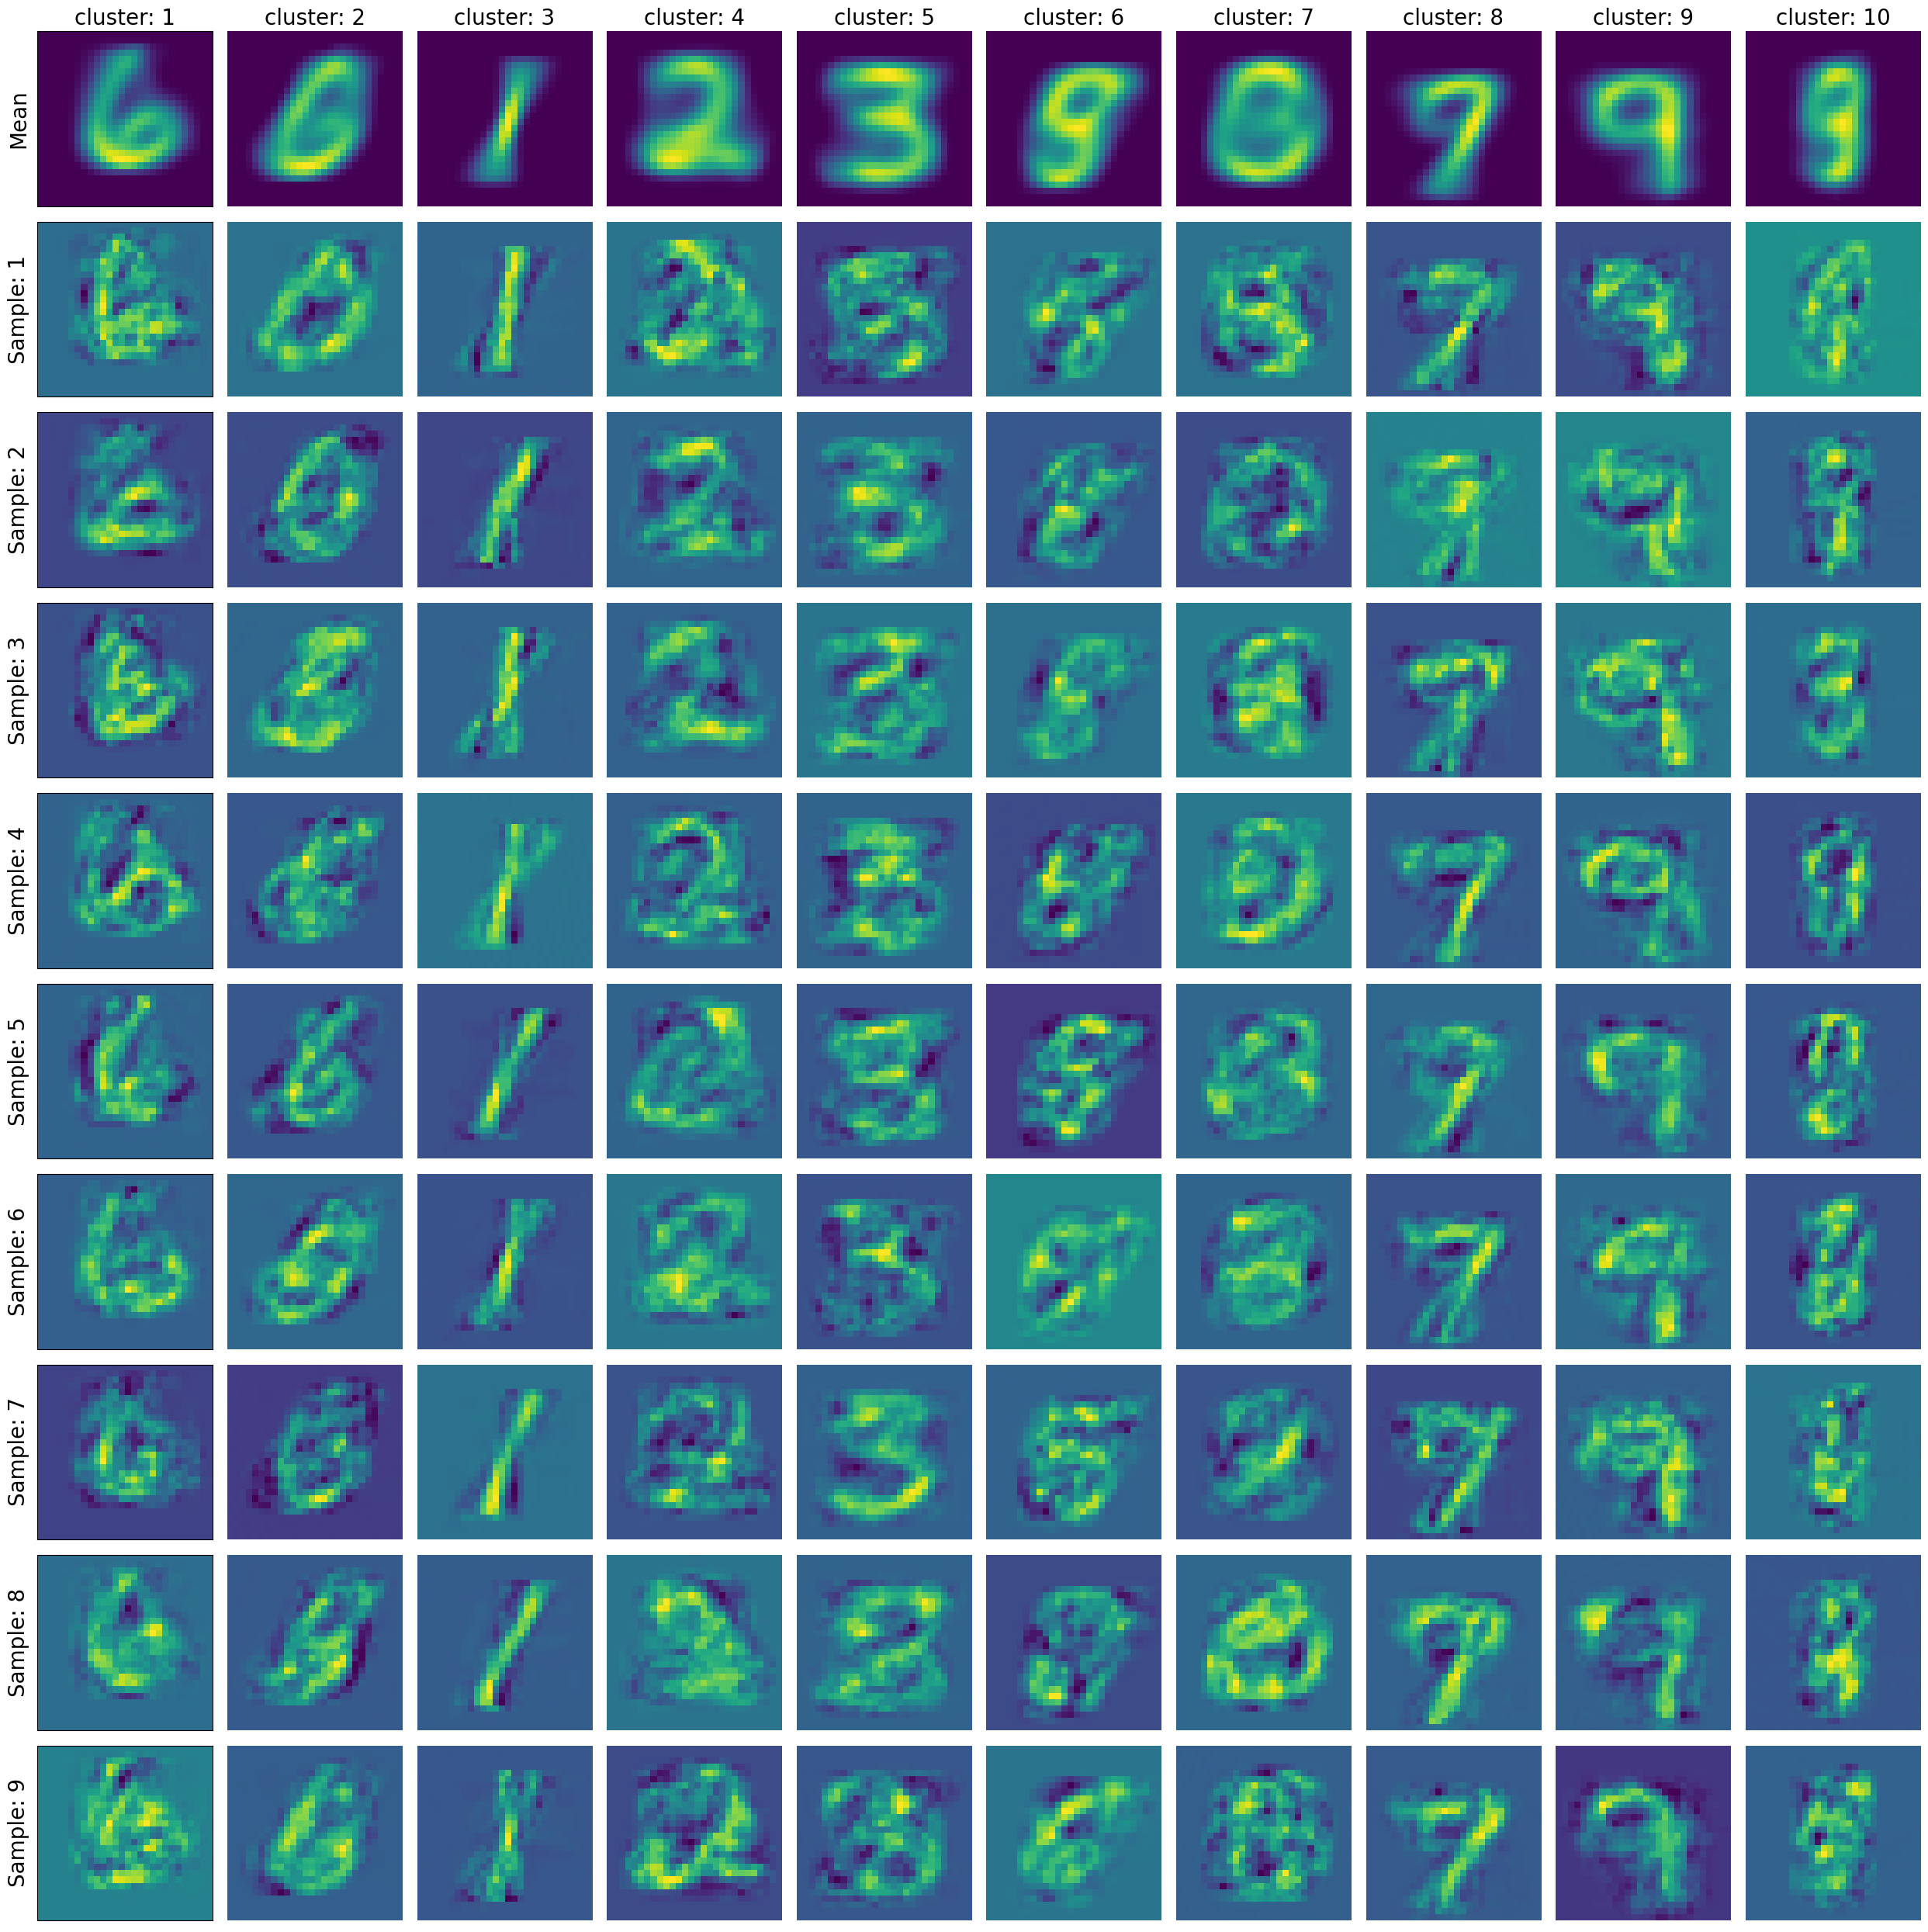

In [55]:
fig, ax = plt.subplots(10,10,figsize=(25,25))

for i in range(10):
    for j in range(1,10):
        ax[i][j].set_axis_off()
        

ax[0][0].get_xaxis().set_visible(False)
ax[0][0].set_ylabel('Mean', fontsize=20)
ax[0][0].set_yticks([])

for i in range(1,10):
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].set_ylabel('Sample: ' + str(i), fontsize=20)
    ax[i][0].set_yticks([])
        
means = torch.from_numpy(model2.means_)
covars = torch.from_numpy(model2.covariances_)


for i in range(10):
    img = means[i].reshape(28,28)
    ax[0][i].imshow(img)
    ax[0][i].set_title("cluster: " + str(i+1), fontsize=20)
    
for i in range(10):
   distri = MultivariateNormal(means[i], covars[i]) 
   for j in range(1,10):
       img = distri.sample().reshape(28,28)
       ax[j][i].imshow(img)
       
       
plt.tight_layout()
fig.savefig('gmm_samples.png', bbox_inches='tight')